In [1]:
pip install astroscrappy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clip
from astropy.visualization import ImageNormalize, LinearStretch, ZScaleInterval
from astroscrappy import detect_cosmics
from astropy.stats import sigma_clipped_stats
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAnnulus
from photutils.aperture import ApertureStats
from photutils.profiles import RadialProfile
from photutils.centroids import centroid_1dg

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
bias_list = [f'~/work/ccd-reductions-mbosch2/Night_2_bias/Bias_BIN1_20250606_025113.fits',
             f'~/work/ccd-reductions-mbosch2/Night_2_bias/Bias_BIN1_20250606_025125.fits',
             f'~/work/ccd-reductions-mbosch2/Night_2_bias/Bias_BIN1_20250606_025138.fits',
             f'~/work/ccd-reductions-mbosch2/Night_2_bias/Bias_BIN1_20250606_025150.fits',
             f'~/work/ccd-reductions-mbosch2/Night_2_bias/Bias_BIN1_20250606_025202.fits'
            ]


In [4]:
def create_median_bias(bias_list, median_bias_filename):
    """This function must:

    - Accept a list of bias file paths as bias_list.
    - Read each bias file and create a list of 2D numpy arrays.
    - Use a sigma clipping algorithm to combine all the bias frames using
      the median and removing outliers outside 3-sigma for each pixel.
    - Save the resulting median bias frame to a FITS file with the name
      median_bias_filename.
    - Return the median bias frame as a 2D numpy array.

    """
    #Reading in the data and adding it into an empty list
    #We use a loop and make sure to take only part of the images to not crash the kernel
    bias_images = []
    for i in bias_list:
        bias_data = fits.getdata(i)
        bias_images.append(bias_data.astype('f4'))
    #We convert the array to a 3D numpy array, then apply sigma_clip with sigma 3

    bias_images_3d = numpy.array(bias_images)
    #bias_mean_2d = numpy.mean(bias_images_3d, axis=0)
    #median_bias = bias_mean_2d[1536:2560, 1536:2560]
    bias_images_masked = sigma_clip(bias_images_3d, cenfunc='median', sigma=3, axis=0)
    #We combine the layers into one bias image using a mean function
    median_bias = numpy.ma.mean(bias_images_masked, axis=0).filled(fill_value=0)

    # This is a placeholder for the actual implementation.
    #median_bias = None

    # Here is some code to create a new FITS file from the resulting median bias frame.
    # You can replace the header with something more meaningful with information.
    primary = fits.PrimaryHDU(data=median_bias, header=fits.Header())
    hdul = fits.HDUList([primary])
    hdul.writeto(median_bias_filename, overwrite=True)

    return median_bias

In [5]:
create_median_bias(bias_list, 'median_bias_2')

array([[1353.8, 1358.8, 1362.6, ..., 1352.4, 1353. , 1353.2],
       [1326. , 1325.8, 1322.8, ..., 1327. , 1318.8, 1327.2],
       [1346.4, 1333.6, 1335.2, ..., 1335.2, 1339.6, 1345.6],
       ...,
       [1344. , 1358.4, 1356.2, ..., 1354.6, 1353.2, 1361. ],
       [1357.4, 1356.6, 1355.6, ..., 1349.6, 1359.8, 1358. ],
       [1361.4, 1363.4, 1360.4, ..., 1363.8, 1358.2, 1364.6]],
      shape=(1024, 1024))

In [6]:
dark_list=[f'~/work/ccd-reductions-mbosch2/Night_2_bias/Dark_BIN1_20250606_025216.fits',
           f'~/work/ccd-reductions-mbosch2/Night_2_bias/Dark_BIN1_20250606_025420.fits',
           f'~/work/ccd-reductions-mbosch2/Night_2_bias/Dark_BIN1_20250606_025624.fits',
           f'~/work/ccd-reductions-mbosch2/Night_2_bias/Dark_BIN1_20250606_025828.fits',
           f'~/work/ccd-reductions-mbosch2/Night_2_bias/Dark_BIN1_20250606_030031.fits'
          ]

In [7]:
def create_median_dark(dark_list, bias_filename, median_dark_filename):
    """This function must:

    - Accept a list of dark file paths to combine as dark_list.
    - Accept a median bias frame filename as bias_filename (the one you created using
      create_median_bias).
    - Read all the images in dark_list and create a list of 2D numpy arrays.
    - Read the bias frame.
    - Subtract the bias frame from each dark image.
    - Divide each dark image by its exposure time so that you get the dark current
      per second. The exposure time can be found in the header of the FITS file.
    - Use a sigma clipping algorithm to combine all the bias-corrected dark frames
      using the median and removing outliers outside 3-sigma for each pixel.
    - Save the resulting dark frame to a FITS file with the name median_dark_filename.
    - Return the median dark frame as a 2D numpy array.

    """
    dark_images=[]
    bias = fits.getdata(bias_filename)
    for i in dark_list:
        dark = fits.open(i)
        dark_data = dark[0].data.astype('f4')
        expt = dark[0].header['EXPTIME']
        expt_div = expt if expt != 0 else 1
        dark_minus_bias = numpy.maximum(dark_data - bias, 0)
        dark_data_no_bias = dark_minus_bias / expt_div
        dark_images.append(dark_data_no_bias)
        
    dark_masked = sigma_clip(dark_images, cenfunc='median', sigma=3, axis=0)
        
    median_dark = numpy.ma.mean(dark_masked, axis=0).filled(fill_value=0)
    

    # See code in create_median_bias for how to create a new FITS file
    # from the resulting median dark frame.
    primary = fits.PrimaryHDU(data=median_dark, header=fits.Header())
    hdul = fits.HDUList([primary])
    hdul.writeto(median_dark_filename, overwrite=True)

    return median_dark

In [8]:
create_median_dark(dark_list, 'median_bias_2', 'median_dark_2')

array([[0.13333333, 0.022     , 0.04966667, ..., 0.089     , 0.12      ,
        0.07866667],
       [0.07      , 0.03066667, 0.07133333, ..., 0.15333333, 0.06433333,
        0.07366667],
       [0.01933333, 0.20333333, 0.11      , ..., 0.034     , 0.08266667,
        0.09366667],
       ...,
       [0.275     , 0.08233333, 0.06533333, ..., 0.101     , 0.11533333,
        0.08833333],
       [0.09066667, 0.44333333, 0.11333333, ..., 0.11266667, 0.04933333,
        0.065     ],
       [0.07966667, 0.027     , 0.01533333, ..., 0.34166667, 0.07033333,
        0.08833333]], shape=(1024, 1024))

In [9]:
flat_list=[f'~/work/ccd-reductions-mbosch2/Night_2_bias/domeflat_r_001.fits',
           f'~/work/ccd-reductions-mbosch2/Night_2_bias/domeflat_r_002.fits',
           f'~/work/ccd-reductions-mbosch2/Night_2_bias/domeflat_r_003.fits',
           f'~/work/ccd-reductions-mbosch2/Night_2_bias/domeflat_r_004.fits',
           f'~/work/ccd-reductions-mbosch2/Night_2_bias/domeflat_r_005.fits'
          ]

In [10]:
def create_median_flat(
    flat_list,
    bias_filename,
    median_flat_filename,
    dark_filename=None,
):
    """This function must:

    - Accept a list of flat file paths to combine as flat_list. Make sure all
      the flats are for the same filter.
    - Accept a median bias frame filename as bias_filename (the one you created using
      create_median_bias).
    - Read all the images in flat_list and create a list of 2D numpy arrays.
    - Read the bias frame.
    - Subtract the bias frame from each flat image.
    - Optionally you can pass a dark frame filename as dark_filename and subtract
      the dark frame from each flat image (remember to scale the dark frame by the
      exposure time of the flat frame).
    - Use a sigma clipping algorithm to combine all the bias-corrected flat frames
      using the median and removing outliers outside 3-sigma for each pixel.
    - Create a normalised flat divided by the median flat value.
    - Save the resulting median flat frame to a FITS file with the name
      median_flat_filename.
    - Return the normalised median flat frame as a 2D numpy array.

    """
    #add filter input for filter, then this works for any filter, default r'
    #even if everything is called r, it will work for anything, check how header works
    flats_r = []
    bias = fits.getdata(bias_filename)
    if dark_filename==None:
        dark=0
    else:
        dark=fits.getdata(dark_filename)
    for i in flat_list:
        flat = fits.open(i)
        if flat[0].header['FILTER'] == "r":
            expt = flat[0].header['EXPTIME']
            flats_r.append(flat[0].data.astype('f4') - bias - dark*expt )

    # Mask using sigma-clipping
    flats_r_masked = sigma_clip(flats_r, cenfunc='median', sigma=3, axis=0)

    # This is a placeholder for the actual implementation.
    combined = numpy.ma.median(flats_r_masked, axis=0).data
    flat_median = numpy.ma.median(combined)
    median_flat = combined/flat_median
    median_flat[combined == 0] = 1

    # See code in create_median_bias for how to create a new FITS file
    # from the resulting median flat frame.
    primary = fits.PrimaryHDU(data=median_flat, header=fits.Header())
    hdul = fits.HDUList([primary])
    hdul.writeto(median_flat_filename, overwrite=True)

    return median_flat

In [11]:
create_median_flat(flat_list, 'median_bias_2', 'median_flat_2', 'median_dark_2')

array([[0.97889828, 0.97849536, 0.96271308, ..., 1.00931317, 1.00538159,
        0.99199751],
       [0.99454479, 0.97832757, 0.98879457, ..., 1.00008133, 1.00376517,
        0.99490801],
       [0.99617571, 0.98381017, 1.00042661, ..., 1.00263541, 0.99778738,
        0.99589519],
       ...,
       [0.97399246, 0.96372219, 0.97645041, ..., 0.99874224, 1.01054307,
        1.00535164],
       [0.97512874, 0.95967712, 0.98096842, ..., 1.00406325, 1.00124601,
        1.00418481],
       [0.97432938, 0.96903883, 0.98185954, ..., 1.00442088, 1.00804545,
        1.00305817]], shape=(1024, 1024))

In [12]:
def plot_flat(
    median_flat_filename,
    output_filename="median_flat.png",
    profile_output_filename="median_flat_profile.png",
):
    """This function must:

    - Accept a normalised flat file path as median_flat_filename.
    - Read the flat file.
    - Plot the flat frame using matplotlib.imshow with reasonable vmin and vmax
      limits. Save the plot to the file specified by output_filename.
    - Take the median of the flat frame along the y-axis. You'll end up with a
      1D array.
    - Plot the 1D array using matplotlib.
    - Save the plot to the file specified by profile_output_filename.

    """
    flat = fits.getdata(median_flat_filename)
    # Plot the combined flat
    plt.figure
    
    norm = ImageNormalize(flat, interval=ZScaleInterval(), stretch=LinearStretch())
    plt.imshow(flat, origin='lower', norm=norm, cmap='YlOrBr_r') #after origin vmin=0.72 and vmax=1.2\
    plt.colorbar(label='Normalized flat value')
    plt.savefig(output_filename)
    
    
    #Flatten image to create a 1D array
    oneD = numpy.median(flat, axis=0).data
    plt.plot(oneD[0])
    plt.savefig(profile_output_filename)

    return 

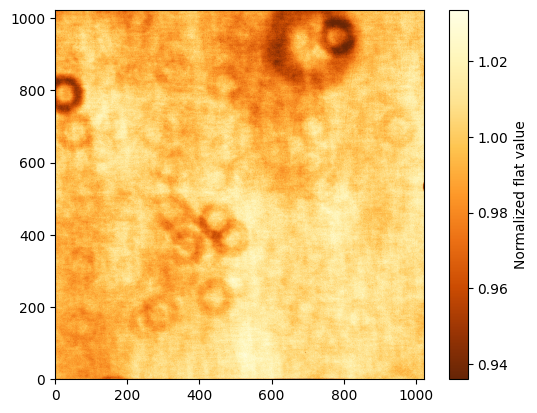

In [13]:
plot_flat('median_flat_2')

In [14]:
from astroscrappy import detect_cosmics

In [15]:
def reduce_science_frame(
    science_filename,
    median_bias_filename,
    median_flat_filename,
    median_dark_filename,
    output_dir=".",
    reduced_science_filename="reduced_science.fits",
):
    """This function must:

    - Accept a science frame filename as science_filename.
    - Accept a median bias frame filename as median_bias_filename (the one you created
      using create_median_bias).
    - Accept a median flat frame filename as median_flat_filename (the one you created
      using create_median_flat).
    - Accept a median dark frame filename as median_dark_filename (the one you created
      using create_median_dark).
    - Read all files.
    - Subtract the bias frame from the science frame.
    - Subtract the dark frame from the science frame. Remember to multiply the
      dark frame by the exposure time of the science frame. The exposure time can
      be found in the header of the FITS file.
    - Correct the science frame using the flat frame.
    - Optionally, remove cosmic rays.
    - Save the resulting reduced science frame to a FITS file with the filename
      reduced_science_filename.
    - Return the reduced science frame as a 2D numpy array.

    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Extract the base filename (e.g., "file.fits") from the full path
    base_filename = os.path.basename(science_filename)
    
    # Construct full path for the output file
    output_path = os.path.join(output_dir, base_filename)
    
    science = fits.open(science_filename)
    science_data = science[0].data.astype('f4')

    #Subtract bias
    bias_data = fits.getdata(median_bias_filename).astype('f4')
    science_data_proc = science_data - bias_data

    # Get the exposure time from the header
    exptime = science[0].header['EXPTIME']

    # Subtract the dark current, scaled to the exposure time
    dark_data = fits.getdata(median_dark_filename).astype('f4')
    dark_data_scaled = dark_data * exptime
    science_data_proc -= dark_data_scaled

    # Divide by the normalised flat-field image
    flat_data = fits.getdata(median_flat_filename).astype('f4')
    science_data_proc /= flat_data

    # Generate the cosmic ray mask and a cleaned image
    mask, reduced_science = detect_cosmics(science_data_proc)

    # Save the final image to disk
    science_hdu = fits.PrimaryHDU(data=reduced_science, header=science[0].header)
    science_hdu.header['COMMENT'] = 'Final science image'
    #science_hdu.header['BIASFILE'] = ('median_bias_filename', 'Bias image used to subtract bias level')
    #science_hdu.header['DARKFILE'] = ('median_dark_filename', 'Dark image used to subtract dark current')
    #science_hdu.header['FLATFILE'] = ('median_flat_filename', 'Flat-field image used to correct flat-fielding')
    science_hdu.writeto(output_path, overwrite=True)
    return reduced_science

In [16]:
    import os
    directory_path = os.path.expanduser('ARCSAT_2')
    file_list=[]
    for file_name in os.listdir(directory_path):
    #Check if it is a file
        if os.path.isfile(os.path.join(directory_path, file_name)):
            file_list.append(file_name)

    bias_list=[]
    dark_list=[]
    flat_list=[]
    science_list=[]
    for i in file_list:
        data = fits.open(directory_path +'/'+ i)
        if data[0].header['IMAGETYP'] == "BIAS":
            bias_list.append(directory_path +'/'+i)
        if data[0].header['IMAGETYP'] == "DARK":
            dark_list.append(directory_path +'/'+i)
        if data[0].header['IMAGETYP'] == "FLAT":
            flat_list.append(directory_path+'/'+i)
        else: science_list.append(directory_path+'/'+i)

In [17]:
len(science_list)

100

In [18]:
for i in science_list:
    reduce_science_frame(i, 'median_bias_2', 'median_flat_2', 'median_dark_2', output_dir='Processed_2', reduced_science_filename= i)

In [19]:
data1 = fits.getdata(f'~/work/ccd-reductions-mbosch2/Night_2_bias/domeflat_r_001.fits').astype('f4')
data2 = fits.getdata(f'~/work/ccd-reductions-mbosch2/Night_2_bias/domeflat_r_002.fits').astype('f4')


flat_diff = data1 - data2
flat_diff_var = numpy.var(flat_diff)

# Get the signal as the average of the two images
mean_signal = 0.5 * numpy.mean(data1 + data2)
    
#Calculate the gain
gain = float(2 * mean_signal / flat_diff_var)


data1 = fits.getdata(f'~/work/ccd-reductions-mbosch2/Night_2_bias/Bias_BIN1_20250606_025113.fits').astype('f4')
data2 = fits.getdata(f'~/work/ccd-reductions-mbosch2/Night_2_bias/Bias_BIN1_20250606_025125.fits').astype('f4')

flat_diff = data1 - data2
flat_diff_var = numpy.var(flat_diff)

# Calculate the readout noise
readout_noise_adu = numpy.sqrt(flat_diff_var / 2)
readout_noise = float(readout_noise_adu * gain)

print(gain)
print(readout_noise)

1.4248473644256592
17.488502502441406
